In [1]:
import pandas as pd
import numpy as np
import torch as pt
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm as tq

#pt.set_default_tensor_type('torch.FloatTensor')
pt.set_default_tensor_type('torch.cuda.FloatTensor')

### Linear Regression Segment

In [2]:
def learn(feature_data, target_data, iters = 100, learn_rate = 1e-2, alpha = 0.2, beta = 0.1, clamp = 1e-16, tqdm = False):
    feature_count = feature_data.shape[1]
    
    feature_tensor = pt.from_numpy(feature_data).type(pt.Tensor)
    target_tensor = pt.from_numpy(target_data).type(pt.Tensor)
    coefs_tensor = pt.zeros(feature_count+1,1)
    
    grad = None
    grad_sq = None

    loss_rcd = []
    t = tq.tnrange(iters, leave = False) if tqdm else range(iters)
    for i in t:
        coefs_tensor.requires_grad = True

        predict_tensor = (feature_tensor @ coefs_tensor[1:]) + coefs_tensor[0]
        error = (target_tensor - predict_tensor) ** 2
        loss = error.mean(dim = 0).sum()

        loss_rcd.append(loss.detach().cpu().numpy())
        if tqdm: t.set_postfix({'loss': loss_rcd[-1]})

        coefs_grad = pt.autograd.grad(loss, coefs_tensor)[0]

        with pt.no_grad():
            grad = coefs_grad if grad is None else (alpha * coefs_grad) + ((1-alpha) * grad)
            grad_sq = coefs_grad ** 2 if grad_sq is None else (beta * (coefs_grad ** 2)) + ((1-beta) * grad_sq)
            step_size = grad / pt.clamp(pt.sqrt(grad_sq), clamp, np.inf)
            coefs_tensor -= step_size * learn_rate
            
    return (loss_rcd, coefs_tensor.detach().cpu().numpy())

In [10]:
feature_count = 3
obs_count = 1000000
sample_size = 1000
iter_count = 1000
internal_iters = 250

working_data = pd.DataFrame(np.random.normal(
    loc = np.random.normal(size = feature_count),
    scale = np.random.normal(size = feature_count) ** 2,
    size = (obs_count, feature_count)
))

pop_coefs = pd.DataFrame(np.random.normal(size = (feature_count+1, 1)), index = ['const', *range(feature_count)], columns = ['coefs'])

working_data['actual'] = (working_data[list(range(feature_count))] @ pop_coefs.loc[list(range(feature_count))]) + pop_coefs.loc['const']# + working_data['error']
working_data['error'] = np.random.normal(size = (obs_count,1))
working_data['target'] = working_data['actual'] + working_data['error']

In [11]:
coefs_record = []
feature_record = []
target_record = []
losses = []
for i in tq.tnrange(iter_count):
    sample_idx = np.random.choice(working_data.index, size = sample_size, replace = False)
    feature_data = working_data.loc[sample_idx, list(range(feature_count))].values
    target_data = working_data.loc[sample_idx, ['target']].values
    loss_record, learn_coefs = learn(feature_data, target_data, iters = internal_iters)
    coefs_record.append(learn_coefs)
    feature_record.append(feature_data)
    target_record.append(target_data)
    losses.append(loss_record)
    
coefs_record = pd.DataFrame(np.concatenate(coefs_record, axis = 1), index = pop_coefs.index)
losses = pd.DataFrame(np.array(losses))

/home/cherryj/conda/envs/standard/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/cherryj/conda/envs/standard/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


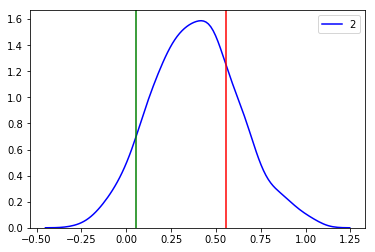

In [17]:
coef = 2
sns.kdeplot(coefs_record.loc[coef], c = 'b')
plt.axvline(pop_coefs.loc[coef, 'coefs'], c = 'r')
plt.axvline(coefs_record.loc[coef, 999], c = 'g')

In [13]:
coef_error = coefs_record.std(axis = 1).to_frame()
coef_error[1] = np.sqrt((working_data['error'] ** 2).mean() * np.diag(np.linalg.inv(np.insert(working_data[list(range(feature_count))].values, 0, 1, axis = 1).T @ np.insert(working_data[list(range(feature_count))].values, 0, 1, axis = 1))))
coef_error[2] = np.sqrt(loss_record[-1] * np.diag(np.linalg.inv(np.insert(feature_data, 0, 1, axis = 1).T @ np.insert(feature_data, 0, 1, axis = 1))))
coef_error.columns = ['actual', 'calc_all', 'calc_recent']
coef_error

,actual,calc_all,calc_recent
const,0.235410,0.077426,2.430866
0,0.308021,0.095437,2.963276
1,0.109522,0.003364,0.104033
2,0.238069,0.026791,0.825596


### Simple Neural Network Segment

In [160]:
def learn_nn(feature_data, target_data, hidden_nodes, iters = 100, learn_rate = 1e-2, alpha = 0.2, beta = 0.1, clamp = 1e-16, tqdm = False):
    feature_count = feature_data.shape[1]
    
    feature_tensor = pt.from_numpy(feature_data).type(pt.Tensor)
    target_tensor = pt.from_numpy(target_data).type(pt.Tensor)
    coefs_tensor = [
        pt.randn(feature_count+1, hidden_nodes),
        pt.randn(hidden_nodes+1, 1)
    ]
    
    grad = [0] * 2
    grad_sq = [0] * 2
    
    loss_rcd = []
    
    t = tq.tnrange(iters, leave = False) if tqdm else range(iters)
    for i in t:
        coefs_tensor[0].requires_grad = True
        coefs_tensor[1].requires_grad = True

        layer_1 = (feature_tensor @ coefs_tensor[0][1:,:]) + coefs_tensor[0][0,:]
        layer_2 = (layer_1 @ coefs_tensor[1][1:,:]) + coefs_tensor[1][0,:]
        error = (target_tensor - layer_2) ** 2
        loss = error.mean(dim = 0).sum()

        loss_rcd.append(loss.detach().cpu().numpy())
        if tqdm: t.set_postfix({'loss': loss_rcd[-1]})

        coefs_grad = pt.autograd.grad(loss, coefs_tensor)

        with pt.no_grad():
            grad = [(alpha * new_grad) + ((1-alpha) * grad_itm) for new_grad, grad_itm in zip(coefs_grad, grad)]
            grad_sq = [(beta * (new_grad**2)) + ((1-beta) * grad_itm) for new_grad, grad_itm in zip(coefs_grad, grad_sq)]
            step_size = [grad_upd / pt.clamp(pt.sqrt(grad_sq_upd), clamp, np.inf) for grad_upd, grad_sq_upd in zip(grad, grad_sq)]
            coefs_tensor = [coefs - (steps * learn_rate) for coefs, steps in zip(coefs_tensor, step_size)]
            
    return (loss_rcd, [coefs.detach().cpu().numpy() for coefs in coefs_tensor])

In [166]:
feature_count = 3
obs_count = 1000000
sample_size = 1000
iter_count = 1000
internal_iters = 250
hidden_nodes = 4

working_data = pd.DataFrame(np.random.normal(
    loc = np.random.normal(size = feature_count),
    scale = np.random.normal(size = feature_count) ** 2,
    size = (obs_count, feature_count)
))

pop_coefs = [
    pd.DataFrame(np.random.normal(size = (feature_count+1, hidden_nodes)), index = ['const', *range(feature_count)]),
    pd.DataFrame(np.random.normal(size = (hidden_nodes+1, 1)), index = ['const', *range(hidden_nodes)])
]

layer_1 = (working_data[list(range(feature_count))] @ pop_coefs[0].loc[list(range(feature_count)),:]) + pop_coefs[0].loc['const', :]
working_data['actual'] = (layer_1 @ pop_coefs[1].loc[list(range(hidden_nodes)),:]) + pop_coefs[1].loc['const', :]
working_data['error'] = np.random.normal(scale = 0.1, size = (obs_count,1))
working_data['target'] = working_data['actual'] + working_data['error']

In [167]:
coefs_record = []
loss_record = []
for i in tq.tnrange(1000):
    sample_idx = np.random.choice(working_data.index, size = sample_size, replace = False)
    feature_data = working_data.loc[sample_idx, list(range(feature_count))].values
    target_data = working_data.loc[sample_idx, ['target']].values
    losses, coefs = learn_nn(feature_data, target_data, hidden_nodes, iters = internal_iters, tqdm = False)
    coefs_record.append(coefs)
    loss_record.append(losses)

In [168]:
loss_full, coefs_full = learn_nn(working_data[list(range(feature_count))].values, working_data[['target']].values, hidden_nodes, iters = 250, tqdm = True)

In [169]:
coef_data = {'layer_0': {},'layer_1': {}}

for coefs in coefs_record:
    for node in range(coefs[0].shape[1]):
        node_name = 'node_%s' % node
        if node_name not in coef_data['layer_0'].keys():
            coef_data['layer_0'][node_name] = {'boot':[]}
        coef_data['layer_0'][node_name]['boot'].append(coefs[0][:,node])
        
    for node in range(coefs[1].shape[1]):
        node_name = 'node_%s' % node
        if node_name not in coef_data['layer_1'].keys():
            coef_data['layer_1'][node_name] = {'boot':[]}
        coef_data['layer_1'][node_name]['boot'].append(coefs[1][:,node])
        
for key in coef_data['layer_0'].keys():
    coef_data['layer_0'][key]['boot'] = np.stack(coef_data['layer_0'][key]['boot'])
    
for key in coef_data['layer_1'].keys():
    coef_data['layer_1'][key]['boot'] = np.stack(coef_data['layer_1'][key]['boot'])
    

for node in range(coefs_full[0].shape[1]):
    coef_data['layer_0']['node_%s' % node]['full'] = coefs_full[0][:,node]
    
for node in range(coefs_full[1].shape[1]):
    coef_data['layer_1']['node_%s' % node]['full'] = coefs_full[1][:,node]
    

for node in range(pop_coefs[0].shape[1]):
    coef_data['layer_0']['node_%s' % node]['actual'] = pop_coefs[0].values[:,node]
    
for node in range(pop_coefs[1].shape[1]):
    coef_data['layer_1']['node_%s' % node]['actual'] = pop_coefs[1].values[:,node]

/home/cherryj/conda/envs/standard/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/cherryj/conda/envs/standard/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/home/cherryj/conda/envs/standard/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/home/cherryj/conda/envs/standard/lib/python3.6/site-packages/matplotlib/cbook/__init

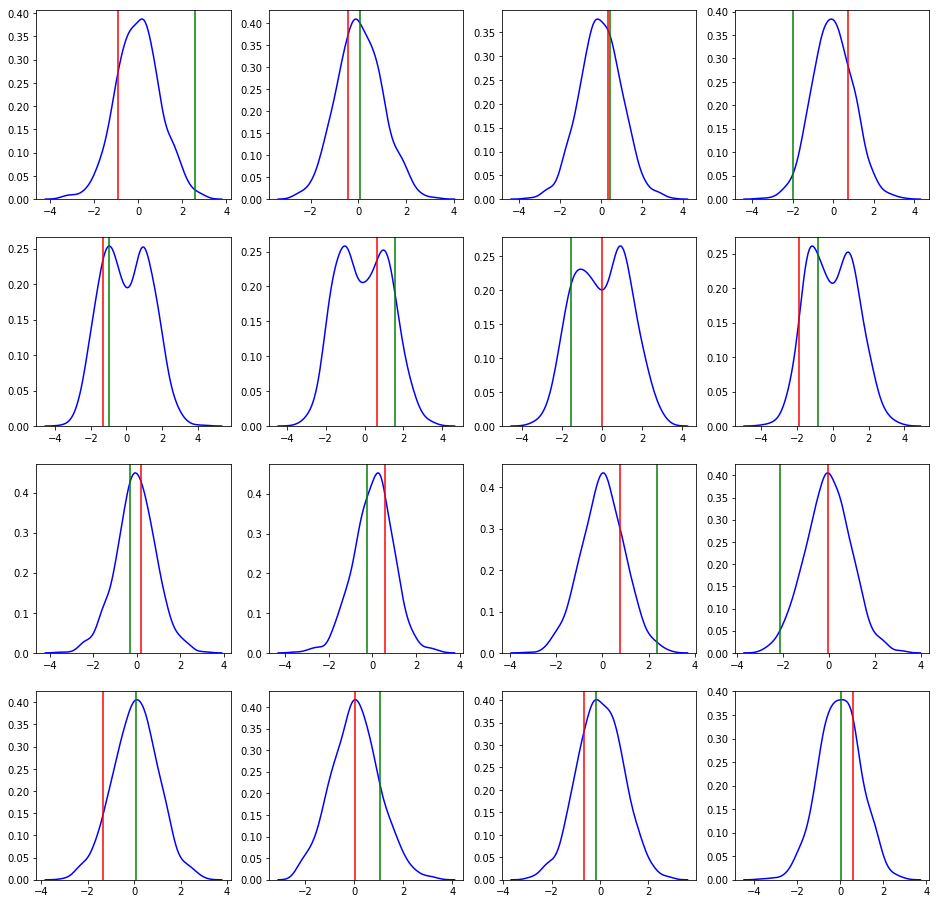

In [170]:
f, ax = plt.subplots(feature_count+1, hidden_nodes, figsize = (16,16))
for inp in range(feature_count+1):
    for node in range(hidden_nodes):
        node_name = 'node_%s' % node
        sns.kdeplot(coef_data['layer_0'][node_name]['boot'][:,inp], c = 'b', ax = ax[inp,node])
        ax[inp,node].axvline(coef_data['layer_0'][node_name]['full'][inp], c = 'r')
        ax[inp,node].axvline(coef_data['layer_0'][node_name]['actual'][inp], c = 'g')